In [34]:
# imports
import math
import numpy as np
import import_ipynb     # won't need this at the end
from Vision import Vision           # Will be 'from Vision import Vision'
import matplotlib.pyplot as plt
from matplotlib import colors

In [35]:
class Global_navigation:
  def __init__(self, grid, start, goal, width_map_cm):
    self.grid = grid
    self.height = grid.shape[0]
    self.width = grid.shape[1]
    self.start = start
    self.goal = goal
    self.max_val = max(self.height, self.width)
    self.size_thymio = 11.2 # centimeters
    self.radius = math.floor(self.size_thymio/(2*(width_map_cm/self.width))) + 1 # number of squares not to use in the algorithm for
                                                                                  # the Thymio to stay out of the fixed obstacles
                                                                                  # or hardcode it if too complicated to have
    self.path = []

  def Plot(self, visitedNodes, path):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, self.max_val+1, 5)
    minor_ticks = np.arange(0, self.max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,self.height])
    ax.set_xlim([-1,self.width])
    ax.grid(True)
    
    cmap = colors.ListedColormap(['white', 'red']) # Select the colors with which to display obstacles and free cells

    # Plot the best path found and the list of visited nodes
    ax.scatter(visitedNodes[1], visitedNodes[0], marker="o", color = 'orange')
    ax.plot(path[1], path[0], marker="o", color = 'blue')
    ax.scatter(self.start[1], self.start[0], marker="o", color = 'green', s=200)
    ax.scatter(self.goal[1], self.goal[0], marker="o", color = 'purple', s=200)
    # Displaying the map
    ax.imshow(self.grid, cmap=cmap)

# – Display plot if the A-star was called and was successful
    
  def A_star_run(self):
    self.grid = grid_adjustement(self.grid, self.height, self.width, self.radius)
    self.path, visitedNodes, plot_possible = launch_A_star(self.start, self.goal, self.width, self.height, self.grid)

    if plot_possible:
      self.Plot(visitedNodes, self.path)

  def getPath(self):
    return self.path
  

In [36]:

                                             ### FUNCTIONS TO PUT AFTER THE CLASS ###    

def neighbors(row_number, column_number, radius, occupancy_grid):
  """
  Construction of a matrix of neighbouring squares 
  
  :param row_number: row position of the center square
  :param column_number: column position of the center square
  :param radius: distance around the center square
  :param occupancy_grid: matrix from which return is processed
  :return: matrix of neighboring squares from the center square and for a distance around it of "radius"
  """
  return np.matrix([[occupancy_grid[i][j] if  i >= 0 and i < len(occupancy_grid) and j >= 0 and j < len(occupancy_grid[0]) else 0
              for j in range(column_number-1-radius, column_number+radius)]
                  for i in range(row_number-1-radius, row_number+radius)])

def grid_adjustement(occupancy_grid, height, width, radius):
  """
  Adjust the map to have obstacles widen of a bit more than half the size of the Thymio

  :param occupancy_grid: matrix of 1 and 0, 1 for an obstacle, 0 for free space
  :param height: height of the map
  :param width: width of the map
  :return: adjusted map with obstacles widen
  """
  occupancy_neighbors = occupancy_grid.copy()
  for i in range(height):
    for j in range(width):
      sum_obstacles = np.matrix.sum(neighbors(i, j, radius, occupancy_grid))
      if sum_obstacles != 0:
        occupancy_neighbors[i][j] = 1
  return occupancy_neighbors


In [37]:
def _get_movements_8n():
  """
  Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
  (up, down, left, right and the 4 diagonals).
  :return: list of movements with cost [(dx, dy, movement_cost)]
  """
  s2 = math.sqrt(2)
  return [(1, 0, 1.0),
          (0, 1, 1.0),
          (-1, 0, 1.0),
          (0, -1, 1.0),
          (1, 1, s2),
          (-1, 1, s2),
          (-1, -1, s2),
          (1, -1, s2)]


def reconstruct_path(cameFrom, current):
  """
  Recurrently reconstructs the path from start node to the current node
  :param cameFrom: map (dictionary) containing for each node n the node immediately 
                    preceding it on the cheapest path from start to n 
                    currently known.
  :param current: current node (x, y)
  :return: list of nodes from start to current node
  """
  total_path = [current]
  while current in cameFrom.keys():
    # Add where the current node came from to the start of the list
    total_path.insert(0, cameFrom[current]) 
    current=cameFrom[current]
  return total_path

def A_Star(start, goal, h, coords, occupancy_grid, height, width):
  """
  A* for 2D occupancy grid. Finds a path from start to goal.
  h is the heuristic function. h(n) estimates the cost to reach goal from node n.
  :param start: start node (x, y)
  :param goal_m: goal node (x, y)
  :param occupancy_grid: the grid map
  :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
  :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
  """
  
  # Check if the start and goal are within the boundaries of the map
  assert 0 <= start[0] < height and 0 <= start[1] < width, "start not contained in the map"
  assert 0 <= goal[0] < height and 0 <= goal[1] < width, "goal not contained in the map"  

  # for point in [start, goal]:
  #   for coord in point:
  #     assert coord>=0 and coord<max_val, "start or end goal not contained in the map"
  
  # check if start and goal nodes correspond to free spaces
  if occupancy_grid[start[0], start[1]]:
    raise Exception('Start node is not traversable')

  if occupancy_grid[goal[0], goal[1]]:
    raise Exception('Goal node is not traversable')
  
  movements = _get_movements_8n()

  
  # --------------------------------------------------------------------------------------------
  #                                  A* Algorithm implementation 
  # --------------------------------------------------------------------------------------------
  
  # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
  # Initially, only the start node is known.
  openSet = [start]
  
  # The set of visited nodes that no longer need to be expanded.
  closedSet = []

  # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
  cameFrom = dict()

  # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
  gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
  gScore[start] = 0

  # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
  fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
  fScore[start] = h[start]

  # while there are still elements to investigate
  while openSet != []:
    
    #the node in openSet having the lowest fScore[] value
    fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
    current = min(fScore_openSet, key=fScore_openSet.get)
    del fScore_openSet
    
    #If the goal is reached, reconstruct and return the obtained path
    if current == goal:
      return reconstruct_path(cameFrom, current), closedSet

    openSet.remove(current)
    closedSet.append(current)
    
    #for each neighbor of current:
    for dx, dy, deltacost in movements:
      
      neighbor = (current[0]+dx, current[1]+dy)
      
      # if the node is not in the map, skip
      if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
        continue
      
      # if the node is occupied or has already been visited, skip
      if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
        continue
          
      # d(current,neighbor) is the weight of the edge from current to neighbor
      # tentative_gScore is the distance from start to the neighbor through current
      tentative_gScore = gScore[current] + deltacost
      
      if neighbor not in openSet:
        openSet.append(neighbor)
          
      if tentative_gScore < gScore[neighbor]:
        # This path to neighbor is better than any previous one. Record it!
        cameFrom[neighbor] = current
        gScore[neighbor] = tentative_gScore
        fScore[neighbor] = gScore[neighbor] + h[neighbor]

  # Open set is empty but goal was never reached
  print("No path found to goal")
  return [], closedSet

def launch_A_star(start, goal, width, height, occupancy_grid):
  """
  Define needed parameters for the A_star algorithm and run the A_star
  :param start:
  :param goal:
  :param width:
  :param height:
  :param occupancy_grid:
  :return: a boolean value to verify if the
  
  """
  x,y = np.mgrid[0:height:1, 0:width:1]
  pos = np.empty(x.shape + (2,))
  pos[:, :, 0] = x; pos[:, :, 1] = y
  pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
  coords = list([(int(x[0]), int(x[1])) for x in pos])

  # Define the heuristic, here = distance to goal ignoring obstacles
  h = np.linalg.norm(pos - goal, axis=-1)
  h = dict(zip(coords, h))

  # Run the A_star algorithm
  path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, height, width)
  path = np.array(path).reshape(-1, 2).transpose()
  visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
  plot_possible = False
  if path.any():
    plot_possible = True            
  return path, visitedNodes, plot_possible

In [32]:
#### TEST CELLS ####

data = np.random.rand(37,50) * 20 # change to get it from vision -

limit = 19.7
occupancy_grid = data.copy()
occupancy_grid[data>limit] = 1
occupancy_grid[data<=limit] = 0

print(occupancy_grid[0:12, 0:10])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 27 28 29 30 30 31 32 33 34 34 35 35 36 36 37 38 39 40 41 42
 42 42 42 42 42 42 42]


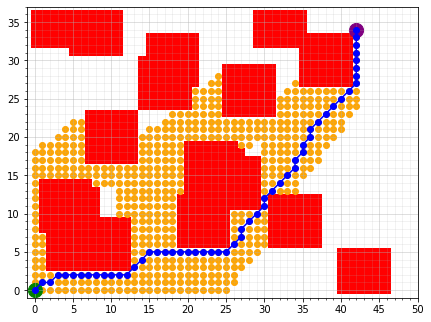

In [38]:
## create function to move with targets !!


# Map = Vision()
# Map.createMap()
# grid = Map.getMap()
X = Global_navigation(occupancy_grid, (0,0), (34,42), 100)

X.A_star_run()
print(X.path[1])

